In [34]:


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model


In [35]:
# 1) LOAD & SPLIT via TFDS
# -------------------------
# 'train' ~3 060 examples,  'test' ~6 084 examples
(ds_train, ds_test), ds_info = tfds.load(
    'caltech101',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True   # returns (image, label) pairs
)

# Further carve out 10% of 'train' as validation
num_train = ds_info.splits['train'].num_examples
val_size = num_train // 10

ds_train = ds_train.shuffle(1000, seed=42)
ds_val   = ds_train.take(val_size)
ds_train = ds_train.skip(val_size)

print(f"Train: {num_train - val_size}  Val: {val_size}  Test: {ds_info.splits['test'].num_examples}")

# Get human‑readable class names
class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes
print(f"Num of classes :  {num_classes}")
print("Classes:", class_names[:5], "...", class_names[-5:])

Train: 2754  Val: 305  Test: 6085
Num of classes :  102
Classes: ['accordion', 'airplanes', 'anchor', 'ant', 'background_google'] ... ['wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']


In [36]:
print("Train element spec:", ds_train.element_spec)
print("Test  element spec:", ds_test.element_spec)

"""
shape=(None, None, 3) means images are RGB but have variable height and width (Caltech 101 images aren’t all the same size).
label is a scalar integer (tf.int64) in the range [0 … num_classes–1] 

"""

n_train = tf.data.experimental.cardinality(ds_train).numpy()
n_test  = tf.data.experimental.cardinality(ds_test).numpy()
print(f"Number of training examples: {n_train}")
print(f"Number of test     examples: {n_test}")


for img, lbl in ds_train.take(1):
    print("Image shape:", img.shape)  # e.g. (300, 451, 3)
    print("Label (int):", lbl.numpy())
    print("Label (class):", class_names[lbl.numpy()])
    break


"""
Batch the dataset with .batch(batch_size) so each element is (batch_of_images, batch_of_labels) with shapes (batch, 180,180,3) and (batch,) respectively
"""

Train element spec: (TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
Test  element spec: (TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
Number of training examples: 2754
Number of test     examples: 6085
Image shape: (301, 456, 3)
Label (int): 37
Label (class): faces


'\nBatch the dataset with .batch(batch_size) so each element is (batch_of_images, batch_of_labels) with shapes (batch, 180,180,3) and (batch,) respectively\n'

In [37]:
# 2) PREPROCESSING FUNCTION
# --------------------------
IMG_SIZE = (180, 180)
def preprocess(image, label):
    # cast & resize to a fixed shape
    image = tf.image.resize(image, IMG_SIZE)
    # normalize to [0,1]
    image = image / 255.0
    return image, label

In [38]:
# 3) BUILD tf.data.Dataset PIPELINES
# ----------------------------------
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    if shuffle:
        # 1) Randomize the order of examples to break any ordering bias.
        #    buffer_size=1000 means it keeps a sliding window of 1k examples
        #    in memory for shuffling; seed=42 makes it reproducible.
        ds = ds.shuffle(1000, seed=42)

    # 2) Apply your `preprocess(image, label)` function to every example,
    #    in parallel (AUTOTUNE lets TensorFlow choose the optimal thread count).
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

    # 3) Group examples into batches of size BATCH_SIZE.
    #    Now each element is (batch_of_images, batch_of_labels).
    ds = ds.batch(BATCH_SIZE)

    # 4) Prefetch the next batch while the current one is being processed
    #    by the GPU/CPU, so training never waits on data I/O.
    ds = ds.prefetch(AUTOTUNE)

    return ds


train_ds = prepare(ds_train, shuffle=True)
val_ds   = prepare(ds_val)
test_ds  = prepare(ds_test)


In [39]:
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)   # (32, 180, 180, 3)
    print("Labels batch shape:", labels.shape)   # (32,)
    print("Image dtype:", images.dtype)          # float32
    print("Label dtype:", labels.dtype)          # int32
    print("Pixel range:", images.numpy().min(), "to", images.numpy().max())


Images batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Pixel range: 0.0 to 1.0


In [40]:
# 4) FUNCTIONAL‑API CNN MODEL
# ----------------------------
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_image")

x = layers.Conv2D(32, 3, activation="relu", name="conv1")(inputs)
x = layers.MaxPooling2D(2, name="pool1")(x)
x = layers.Conv2D(64, 3, activation="relu", name="conv2")(x)
x = layers.MaxPooling2D(2, name="pool2")(x)
x = layers.Conv2D(128, 3, activation="relu", name="conv3")(x)
x = layers.MaxPooling2D(2, name="pool3")(x)

x = layers.Flatten(name="flatten")(x)
x = layers.Dense(256, activation="relu", name="fc1")(x)
x = layers.Dropout(0.5, name="dropout")(x)
outputs = layers.Dense(ds_info.features['label'].num_classes,
                       activation="softmax",
                       name="output_probs")(x)

model = Model(inputs, outputs, name="caltech101_cnn")
model.summary()

Model: "caltech101_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 178, 178, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 89, 89, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 87, 87, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 43, 43, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 41, 41, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 20, 20, 128)    

In [41]:
"""
num_train = ds_info.splits['train'].num_examples  # ≈ 3 060
train_examples = num_train - (num_train // 10)
               = 3060 - 306
               = 2754
train_batches = ceil(2754 / 32) = 87
val_examples  = 306
val_batches   = ceil(306 / 32)  = 10
test_batches  = ceil(6084 / 32) = 191
"""

import tensorflow as tf

num_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
print(f"Number of train batches: {num_train_batches}")


Number of train batches: 87


In [42]:
# 5) COMPILE
# ----------
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [43]:
# 6) TRAIN
# --------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
87/87 [==============================] - 50s 563ms/step - loss: 4.6249 - accuracy: 0.0243 - val_loss: 4.4656 - val_accuracy: 0.0393
Epoch 2/10
87/87 [==============================] - 47s 541ms/step - loss: 4.2854 - accuracy: 0.0759 - val_loss: 3.9190 - val_accuracy: 0.1574
Epoch 3/10
87/87 [==============================] - 48s 548ms/step - loss: 3.7514 - accuracy: 0.1732 - val_loss: 3.1735 - val_accuracy: 0.2689
Epoch 4/10
87/87 [==============================] - 46s 531ms/step - loss: 2.8824 - accuracy: 0.3450 - val_loss: 2.1797 - val_accuracy: 0.5508
Epoch 5/10
87/87 [==============================] - 46s 530ms/step - loss: 2.1142 - accuracy: 0.5025 - val_loss: 1.3232 - val_accuracy: 0.7246
Epoch 6/10
87/87 [==============================] - 48s 553ms/step - loss: 1.4624 - accuracy: 0.6474 - val_loss: 0.9358 - val_accuracy: 0.8557
Epoch 7/10
87/87 [==============================] - 49s 567ms/step - loss: 1.0366 - accuracy: 0.7407 - val_loss: 0.4513 - val_accuracy: 0.9246

In [44]:
# 7) EVALUATE
# -----------
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")

191/191 [==============================] - 32s 165ms/step - loss: 3.5018 - accuracy: 0.4153

Test accuracy: 0.4153


In [45]:
# 8) PREDICT ON A BATCH
# ---------------------
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    for i in range(5):
        print(f"Image {i}: Predicted = {class_names[preds[i]]:15s}  "
              f"True = {class_names[labels[i]]}")

1/1 [==============================] - 0s 301ms/step
Image 0: Predicted = cannon           True = background_google
Image 1: Predicted = stop_sign        True = stop_sign
Image 2: Predicted = motorbikes       True = motorbikes
Image 3: Predicted = crocodile_head   True = pizza
Image 4: Predicted = gramophone       True = background_google


1/1 [==============================] - 0s 133ms/step


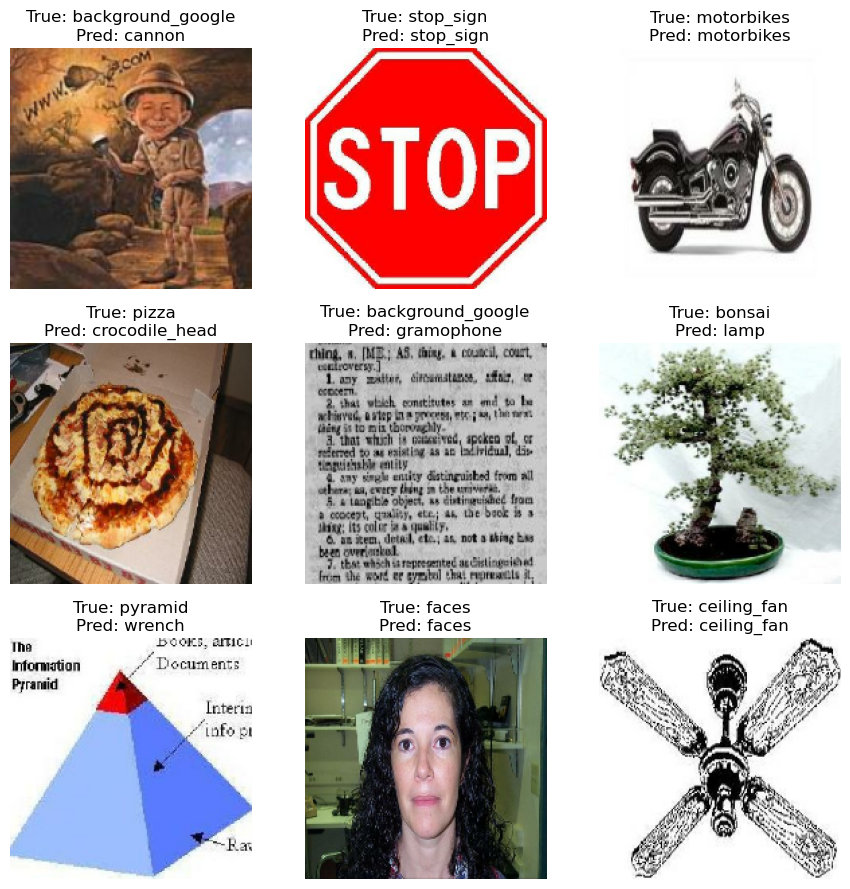

In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualize predictions on one batch from the test set
for images, labels in test_ds.take(1):
    # Model predictions
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1).numpy()
    true_labels = labels.numpy()
    
    # Plot a 3x3 grid of images with true vs. predicted labels
    plt.figure(figsize=(9,9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break
